In [3]:
# --------------------------------------
# Imports & Config
# --------------------------------------
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import (
    fetch_data,
    find_cointegrated_pairs,
    backtest_pairs,
    performance_metrics,
    plot_zscore,
)

plt.style.use("seaborn-v0_8")

# Ensure folders exist for saves
Path("data").mkdir(parents=True, exist_ok=True)
Path("images").mkdir(parents=True, exist_ok=True)

# Optional debug toggle for diagnostics cells
DEBUG = False
print("Environment ready.")

Environment ready.


In [4]:
# --------------------------------------
# Parameters
# --------------------------------------
tickers = ["JPM", "BAC", "WFC", "C", "GS", "MS", "USB", "PNC", "TFC", "BK"]
start_date = "2018-01-01"
end_date = "2025-08-01"

# Strategy parameters (align with utils defaults; change as you wish)
entry_z = 2.0
exit_z = 0.5           # set to 0.0 if you want your previous behavior
z_window = 60
tc_bps = 0.0           # transaction costs framework present but OFF
max_hold_days = 20
stop_z = 3.5
use_ewma = False
ewma_halflife = None
use_intercept = True   # OLS with intercept for hedge ratio

print(f"Universe size: {len(tickers)}; Date range: {start_date} to {end_date}")

Universe size: 10; Date range: 2018-01-01 to 2025-08-01


In [5]:
# --------------------------------------
# Diagnostics
# --------------------------------------
if DEBUG:
    import yfinance as yf
    raw = yf.download(tickers, start=start_date, end=end_date, progress=False)
    print(raw.head())
    print("\nColumns:", raw.columns)
    print("\nIs MultiIndex:", isinstance(raw.columns, pd.MultiIndex))

In [6]:
# --------------------------------------
# Fetch Price Data
# --------------------------------------
prices = fetch_data(tickers, start_date, end_date, save_path="data/prices.csv")
print(f"Downloaded {prices.shape[0]} rows for {prices.shape[1]} tickers.")
display(prices.tail())

2025-09-10 23:03:58,364 INFO utils - Fetching data for 10 tickers from 2018-01-01 to 2025-08-01
2025-09-10 23:04:01,583 INFO utils - Saved prices to data/prices.csv


Downloaded 1905 rows for 10 tickers.


Ticker,BAC,BK,C,GS,JPM,MS,PNC,TFC,USB,WFC
Date,,,,,,,,,,
2025-07-25,48.182003,100.919998,95.442299,725.098389,298.619995,142.023315,196.050003,45.096024,46.320000,83.827538
2025-07-28,47.963219,100.629997,94.925697,719.796814,298.279999,141.576416,193.970001,44.542820,46.090000,82.584839
2025-07-29,47.684769,101.870003,93.862686,728.082458,297.040009,142.569519,193.369995,44.187187,46.090000,82.167297
2025-07-30,47.694714,102.300003,95.183990,726.859009,299.630005,143.940002,192.550003,43.722889,45.880001,81.302376
2025-07-31,47.008530,101.449997,93.087776,719.737183,296.239990,142.460007,190.270004,43.179565,44.959999,80.159088


In [7]:
# --------------------------------------
# Cointegration Tests
# --------------------------------------
pval_matrix, pairs = find_cointegrated_pairs(prices, significance=0.05, min_obs=252)

print("\nCointegrated Pairs (p < 0.05):")
for t1, t2, p in pairs:
    print(f"{t1} & {t2} | p-value = {p:.4f}")

if not pairs:
    raise ValueError("No cointegrated pairs found. Try expanding tickers or date range.")

# Keep the top pair for the single-pair demo
pair = (pairs[0][0], pairs[0][1])
print("\nSelected pair:", pair)

2025-09-10 23:04:05,253 INFO utils - Scanning 10 series for cointegration (EG, trend=c)



Cointegrated Pairs (p < 0.05):
BAC & PNC | p-value = 0.0035
TFC & USB | p-value = 0.0135

Selected pair: ('BAC', 'PNC')


In [ ]:
# --------------------------------------
# Single-Pair Backtest & Plots
# --------------------------------------
equity_curve, daily_returns, zscore = backtest_pairs(
    prices,
    pair,
    entry_z=entry_z,
    exit_z=exit_z,
    z_window=z_window,
    use_ewma=use_ewma,
    ewma_halflife=ewma_halflife,
    max_hold_days=max_hold_days,
    stop_z=stop_z,
    execute_next_bar=True,
    tc_bps=tc_bps,
    use_intercept=use_intercept,
)

metrics = performance_metrics(daily_returns)
print("\nSingle-Pair Performance Report:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(equity_curve, label="Equity Curve")
plt.title(f"Pairs Trading | {pair[0]} vs {pair[1]}")
plt.legend()
plt.show()

plot_zscore(zscore, entry_z=entry_z, exit_z=exit_z, title=f"Spread Z-score: {pair[0]} / {pair[1]}")

In [9]:
# --------------------------------------
# Helpers: batch_backtest and rolling_sharpe
# --------------------------------------
from typing import Dict, List, Tuple

def batch_backtest(
    prices: pd.DataFrame,
    pairs: List[Tuple[str, str, float]],
    entry_z: float,
    exit_z: float,
    z_window: int = 60,
    tc_bps: float = 0.0,
    use_ewma: bool = False,
    ewma_halflife: float | None = None,
    max_hold_days: int | None = 20,
    stop_z: float | None = 3.5,
    use_intercept: bool = True,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Runs backtest for each pair and returns:
      - metrics_df: per-pair performance metrics (+ p-value)
      - returns_df: columns are pair names, values are daily returns
    """
    results: List[dict] = []
    returns_dict: Dict[str, pd.Series] = {}

    for t1, t2, pval in pairs:
        equity, rets, _ = backtest_pairs(
            prices, (t1, t2),
            entry_z=entry_z,
            exit_z=exit_z,
            z_window=z_window,
            use_ewma=use_ewma,
            ewma_halflife=ewma_halflife,
            max_hold_days=max_hold_days,
            stop_z=stop_z,
            execute_next_bar=True,
            tc_bps=tc_bps,
            use_intercept=use_intercept,
        )
        m = performance_metrics(rets)
        m["Pair"] = f"{t1}-{t2}"
        m["p-value"] = pval
        results.append(m)
        returns_dict[m["Pair"]] = rets

    metrics_df = pd.DataFrame(results).set_index("Pair").sort_values("Sharpe Ratio", ascending=False)
    returns_df = pd.DataFrame(returns_dict).sort_index().fillna(0.0)
    return metrics_df, returns_df

def rolling_sharpe(returns: pd.Series, window: int = 126) -> pd.Series:
    """Rolling annualized Sharpe ratio."""
    roll_mean = returns.rolling(window).mean()
    roll_vol = returns.rolling(window).std()
    return (roll_mean / roll_vol) * np.sqrt(252)

,CAGR,Annualized Mean,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Win Rate,p-value
Pair,,,,,,,,
TFC-USB,0.063270,0.067353,0.10973,0.613807,0.969281,-0.151308,0.181627,0.013454
BAC-PNC,0.080761,0.090989,0.16346,0.556647,0.880648,-0.198226,0.152231,0.003504


Metrics saved to data\pair_metrics.csv


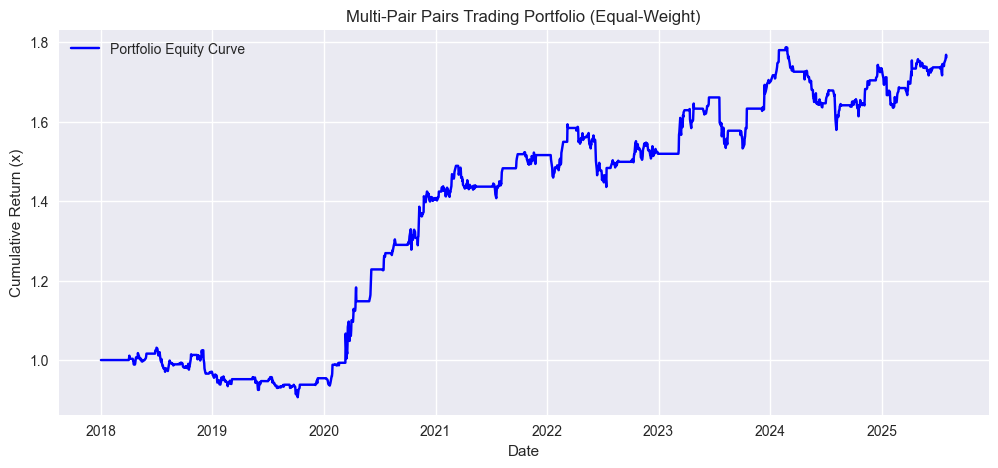

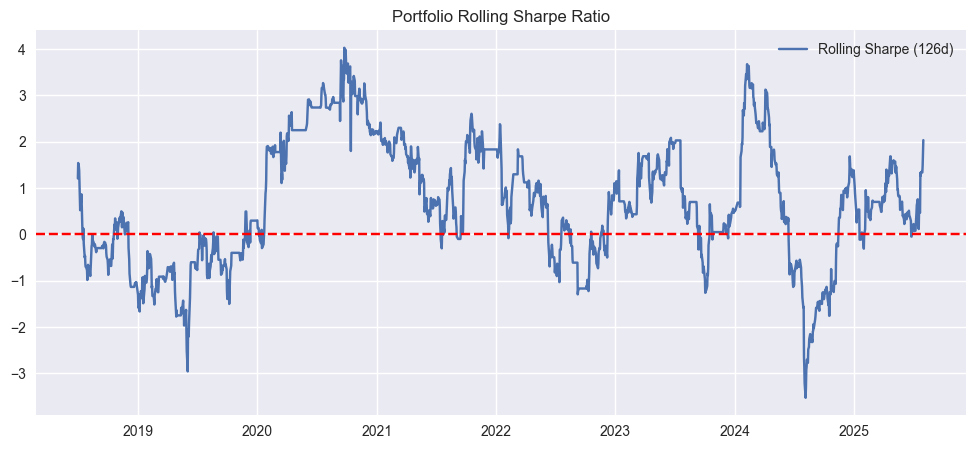


Portfolio Performance:
CAGR: 0.0778
Annualized Mean: 0.0792
Annualized Volatility: 0.0927
Sharpe Ratio: 0.8540
Sortino Ratio: 1.4626
Max Drawdown: -0.1208
Win Rate: 0.2814


In [10]:
# --------------------------------------
# Multi-Pair Portfolio (equal-weight)
# --------------------------------------
metrics_df, returns_df = batch_backtest(
    prices, pairs,
    entry_z=entry_z,
    exit_z=exit_z,
    z_window=z_window,
    tc_bps=tc_bps,
    use_ewma=use_ewma,
    ewma_halflife=ewma_halflife,
    max_hold_days=max_hold_days,
    stop_z=stop_z,
    use_intercept=use_intercept,
)

display(metrics_df.head(10))

# Save metrics
metrics_path = Path("data/pair_metrics.csv")
metrics_df.to_csv(metrics_path)
print(f"Metrics saved to {metrics_path}")

# Equal-weight portfolio across all pairs
portfolio_returns = returns_df.mean(axis=1)
portfolio_equity = (1.0 + portfolio_returns).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(portfolio_equity, label="Portfolio Equity Curve", color="blue")
plt.title("Multi-Pair Pairs Trading Portfolio (Equal-Weight)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (x)")
plt.legend()
plt.show()

rs = rolling_sharpe(portfolio_returns, window=126)
plt.figure(figsize=(12, 5))
plt.plot(rs, label="Rolling Sharpe (126d)")
plt.axhline(0, color="red", linestyle="--")
plt.title("Portfolio Rolling Sharpe Ratio")
plt.legend()
plt.show()

portfolio_metrics = performance_metrics(portfolio_returns)
print("\nPortfolio Performance:")
for k, v in portfolio_metrics.items():
    print(f"{k}: {v:.4f}")

In [ ]:
# --------------------------------------
# Report (heatmap, images, PDF)
# --------------------------------------
import matplotlib.backends.backend_pdf as backend_pdf

# pval_matrix from find_cointegrated_pairs is already a DataFrame
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    pval_matrix, annot=True, fmt=".2f", cmap="coolwarm_r",
    center=0.05, cbar_kws={"label": "p-value"}, ax=ax
)
ax.set_title("Cointegration P-Value Heatmap (Engle–Granger)")
plt.tight_layout()
plt.savefig("images/heatmap_new.png", dpi=300, bbox_inches="tight")
plt.show()

# PDF report
pdf = backend_pdf.PdfPages("Quant_Research_Report.pdf")

# Overview page
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis("off")
overview_text = (
    f"Quant Research Report — Pairs Trading\n\n"
    f"Data Period: {prices.index.min().date()} to {prices.index.max().date()}\n"
    f"Number of Tickers: {len(prices.columns)}\n"
    f"Cointegrated Pairs Found: {len(pairs)}\n"
    f"Top 5 Pairs by Sharpe Ratio:\n" + metrics_df.head(5)[["Sharpe Ratio"]].to_string()
)
ax.text(0.01, 0.95, overview_text, ha="left", va="top", fontsize=10, family="monospace")
pdf.savefig(fig)

# Metrics table page
fig, ax = plt.subplots(figsize=(8, max(5, len(metrics_df) * 0.4)))
ax.axis("off")
ax.set_title("Performance Metrics by Pair", fontweight="bold")
table_data = metrics_df.round(4).reset_index()
ax.table(cellText=table_data.values, colLabels=table_data.columns, loc="center", cellLoc="right", colLoc="right")
pdf.savefig(fig)

# Portfolio equity page
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(portfolio_equity, color="blue", label="Portfolio Equity")
ax.set_title("Portfolio Equity Curve — Equal-Weighted Multi-Pair Strategy")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return (x)")
ax.legend()
pdf.savefig(fig)

# Rolling Sharpe page
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(rs, label="Rolling Sharpe (126 Days)", color="green")
ax.axhline(0, color="red", linestyle="--")
ax.set_title("Portfolio Rolling Sharpe Ratio")
ax.legend()
pdf.savefig(fig)

# Daily returns histogram page
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(portfolio_returns, bins=50, color="grey", edgecolor="black")
ax.set_title("Distribution of Portfolio Daily Returns")
ax.set_xlabel("Daily Return")
ax.set_ylabel("Frequency")
pdf.savefig(fig)

# Portfolio summary page
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis("off")
summary_data = performance_metrics(portfolio_returns)
summary_df = pd.DataFrame(list(summary_data.items()), columns=["Metric", "Value"]).round(4)
ax.table(cellText=summary_df.values, colLabels=summary_df.columns, loc="center", cellLoc="right", colLoc="right")
ax.set_title("Portfolio Performance Summary", fontweight="bold")
pdf.savefig(fig)

# Individual pair pages (equity + z-score)
for t1, t2, _ in pairs:
    equity, rets, z = backtest_pairs(
        prices, (t1, t2),
        entry_z=entry_z, exit_z=exit_z, z_window=z_window,
        use_ewma=use_ewma, ewma_halflife=ewma_halflife,
        max_hold_days=max_hold_days, stop_z=stop_z,
        execute_next_bar=True, tc_bps=tc_bps, use_intercept=use_intercept
    )

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={"height_ratios": [2, 1]})
    axes[0].plot(equity, label=f"Equity: {t1}-{t2}", color="blue")
    axes[0].set_title(f"Equity Curve: {t1} / {t2}")
    axes[0].legend()

    axes[1].plot(z, label="Z-score", color="purple")
    axes[1].axhline(entry_z, color="red", linestyle="--", label="Upper Entry")
    axes[1].axhline(-entry_z, color="green", linestyle="--", label="Lower Entry")
    axes[1].axhline(exit_z, color="grey", linestyle="--", label="Exit")
    axes[1].axhline(-exit_z, color="grey", linestyle="--")
    axes[1].legend()

    plt.savefig(f"images/equity_and_zscore_{t1}_{t2}.png", dpi=300, bbox_inches="tight")
    pdf.savefig(fig)

pdf.close()
print("Quant_Research_Report.pdf saved; images written to images/.")